In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import plotly
import xarray as xr
import netCDF4
import h5netcdf
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import pandas as pd

In [3]:
path = './dataset/sampled_data/2018-07-01.nc'
data = xr.open_dataset(path)

print(data)

<xarray.Dataset> Size: 84MB
Dimensions:                                    (lon: 1386, lat: 585, crs: 1)
Coordinates:
  * lon                                        (lon) float64 11kB -124.8 ... ...
  * lat                                        (lat) float64 5kB 49.4 ... 25.07
    day                                        datetime64[ns] 8B ...
  * crs                                        (crs) uint16 2B 3
Data variables: (12/13)
    burning_index_g                            (lat, lon) float64 6MB ...
    energy_release_component-g                 (lat, lon) float64 6MB ...
    potential_evapotranspiration               (lat, lon) float64 6MB ...
    dead_fuel_moisture_100hr                   (lat, lon) float64 6MB ...
    dead_fuel_moisture_1000hr                  (lat, lon) float64 6MB ...
    precipitation_amount                       (lat, lon) float64 6MB ...
    ...                                         ...
    specific_humidity                          (lat, lon) float64 6

In [5]:
#Extracting only the wind speed and direction
wind_speed = data['wind_speed']
wind_dir = data['wind_from_direction']

print(wind_speed , wind_dir , sep='\n\n\n\n\n')

<xarray.DataArray 'wind_speed' (lat: 585, lon: 1386)> Size: 6MB
[810810 values with dtype=float64]
Coordinates:
  * lon      (lon) float64 11kB -124.8 -124.7 -124.7 ... -67.14 -67.1 -67.06
  * lat      (lat) float64 5kB 49.4 49.36 49.32 49.28 ... 25.15 25.11 25.07
    day      datetime64[ns] 8B ...
Attributes:
    units:              m/s
    description:        Daily Mean Wind Speed
    long_name:          vs
    standard_name:      vs
    dimensions:         lon lat time
    grid_mapping:       crs
    coordinate_system:  WGS84,EPSG:4326




<xarray.DataArray 'wind_from_direction' (lat: 585, lon: 1386)> Size: 6MB
[810810 values with dtype=float64]
Coordinates:
  * lon      (lon) float64 11kB -124.8 -124.7 -124.7 ... -67.14 -67.1 -67.06
  * lat      (lat) float64 5kB 49.4 49.36 49.32 49.28 ... 25.15 25.11 25.07
    day      datetime64[ns] 8B ...
Attributes:
    units:              Degrees Clockwise from north
    description:        Daily mean wind direction
    long_name:          th


In [6]:
!pip install cartopy

   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   -- ------------------------------------- 0.8/11.0 MB 6.7 MB/s eta 0:00:02
   -------- ------------------------------- 2.4/11.0 MB 5.6 MB/s eta 0:00:02
   ------------- -------------------------- 3.7/11.0 MB 5.7 MB/s eta 0:00:02
   ----------------- ---------------------- 4.7/11.0 MB 5.7 MB/s eta 0:00:02
   ---------------------- ----------------- 6.0/11.0 MB 5.8 MB/s eta 0:00:01
   ------------------------- -------------- 7.1/11.0 MB 5.7 MB/s eta 0:00:01
   ------------------------------ --------- 8.4/11.0 MB 5.7 MB/s eta 0:00:01
   ---------------------------------- ----- 9.4/11.0 MB 5.7 MB/s eta 0:00:01
   ---------------------------------------  10.7/11.0 MB 5.6 MB/s eta 0:00:01
   ---------------------------------------- 11.0/11.0 MB 5.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/6.2 MB ? eta -:--:--
   ----- ---------------------------------- 0.8/6.2 MB 5.6 MB/s eta 0:00:01
   ----------

In [7]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [47]:
# Define the bin size for downsampling (e.g., every 2° of lat/lon)
lat_bin_size = 1.5
lon_bin_size = 1.5

In [48]:
lat = wind_speed['lat'].values
lon = wind_speed['lon'].values
speed = wind_speed.values  # Wind speed
direction = wind_dir.values  # Wind direction in degrees

In [49]:
# Create 2D grids for latitudes and longitudes
lon_grid, lat_grid = np.meshgrid(lon, lat)

In [50]:
# Bin the latitudes and longitudes
lat_bins = np.arange(lat.min(), lat.max(), lat_bin_size)
lon_bins = np.arange(lon.min(), lon.max(), lon_bin_size)

In [51]:

# Function to average wind speed and direction within each bin
def bin_average(data, lat, lon, lat_bins, lon_bins):
    binned_data = np.zeros((len(lat_bins) - 1, len(lon_bins) - 1))
    for i in range(len(lat_bins) - 1):
        for j in range(len(lon_bins) - 1):
            mask = (
                (lat >= lat_bins[i]) & (lat < lat_bins[i+1]) & 
                (lon >= lon_bins[j]) & (lon < lon_bins[j+1])
            )
            binned_data[i, j] = data[mask].mean() if np.any(mask) else np.nan
    return binned_data

In [52]:
# Compute binned averages for wind speed and direction
avg_speed = bin_average(speed, lat_grid, lon_grid, lat_bins, lon_bins)
avg_direction = bin_average(direction, lat_grid, lon_grid, lat_bins, lon_bins)


In [53]:
# Convert wind direction and speed into u and v components
u_binned = -avg_speed * np.sin(np.radians(avg_direction))
v_binned = -avg_speed * np.cos(np.radians(avg_direction))

In [54]:
lat_midpoints = (lat_bins[:-1] + lat_bins[1:]) / 2
lon_midpoints = (lon_bins[:-1] + lon_bins[1:]) / 2
lon_mid_grid, lat_mid_grid = np.meshgrid(lon_midpoints, lat_midpoints)


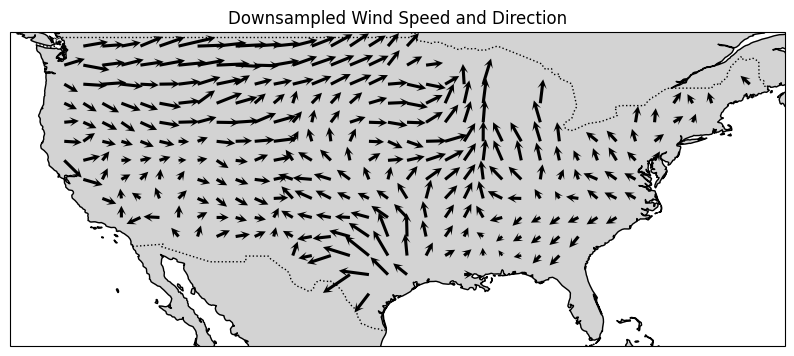

In [55]:
# Create a plot with Cartopy for geographic projection
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Adjust land color to a light color, e.g., beige
ax.add_feature(cfeature.LAND, color='lightgray')

# Add coastlines, borders, and other features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot quiver plot with the binned data
quiver = ax.quiver(
    lon_mid_grid, lat_mid_grid, u_binned, v_binned, 
    scale_units='xy', scale=None, width=0.004, 
    headlength=3, headaxislength=2, color='black'
)

# Add a title and show the plot
plt.title('Downsampled Wind Speed and Direction')
plt.show()